# Problem Statement

#### Motivation

Over the last decade, many companies have incorporated automatic speech recognition into their technology. iPhone users all have access to Siri, which listens to speech and tries to understand what action it should perform. Zoom and Youtube both offer speech-to-text options. Many more applications can be found [here](https://en.wikipedia.org/wiki/Speech_recognition).

For anyone who has used a device that performs speech recognition, they have likely seen the device make numerous errors. Below is an example of a Google Voice error [found on the internet](https://www.technologizer.com/2010/08/22/worst-google-voice-transcription-errors/). Automatic speech recognition is challenging. 
> hi allen my name is white and my number is area code (626) 523-8023 once again the number is (562) 652-3808

There are many things that make speech recognition difficult, one of which is that people frequently make sounds that are not words to be parsed. For example, a person may cough or clear their throat and some speech recognition software would either have to identify it as such, or ignore it altogether and only pick out the spoken words.

#### Problem Statement

Our goal is to train a neural network that takes in short audio files (less than six seconds) and classifies the file as either a cough, laugh, sigh, sneeze, sniff, or throat clear. We will deem our model successful if it achieves an accuracy score of 90% or higher on unseen data.

The hope with this project is that our model could eventually be used alongside a speech recognition model and pick out sounds that the speech recognition model does not need to attempt to parse.


# Loading and Padding Audio Data

## Imports and Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import librosa, librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split

In [41]:
def collect_id_sound(df):
    # extract speaker id and classification from file name
    df['id'] = df['file_name'].str.split('_').str[0]
    df['sound'] = df['file_name'].str.split('_').str[2].str[:-4]
    
    return df

def prepare_data():
    # pull in speaker data and rename columns
    col_names = ['id', 'sex', 'age', 'region', 'language', 'health_cond']
    all_meta = pd.read_csv('../data/speaker_data.csv', header = None, names = col_names)
    
    # file names include id and label data
    # extract store together in a dataframe (filename, id, label)
    wav_files = pd.DataFrame(os.listdir('../audiofiles/'), columns = ['file_name'])
    wav_files = collect_id_sound(wav_files)
    
    # labels listed as strings, convert to int
    sound_to_int = {'cough': 0, 'laughter': 1, 'sigh': 2,
                   'sneeze': 3, 'sniff': 4, 'throatclearing': 5}
    wav_files['sound'] = wav_files['sound'].map(sound_to_int)
    
    # include filename and label data onto train, val, test csv files
    all_meta = all_meta.merge(wav_files, how = 'left', left_on = 'id', right_on = 'id')
    
    # rearrange columns to a preferable order
    order = ['id', 'age', 'sex', 'region', 'language', 'file_name', 'sound']
    all_meta = all_meta[order]
    
    return all_meta

def to_signal(file_name):
    # returns audio signal (trimmed to 6 seconds) from file name
    # if the file is unreadable, return [0]
    audio_folder = '../audiofiles/'
    file_path = audio_folder + file_name
    
    try:
        # librosa.load returns the signal and sample rate
        # [0] only collects the signal
        signal = librosa.load(file_path, duration = 6)[0]
    except:
        signal = [0]
    
    return signal

def six_second_pad(array):
    # takes a 1d-array (audio signal) and appends 0s
    # until it is of length 132,300.
    
    # 132,300 is the size of a 6 second audio clip
    # if the sample rate is 22,050
    
    max_length = 132_300
    num_missing = max_length - len(array)
    padded_array = np.pad(array = array, pad_width = (0, num_missing), mode = 'constant')
    
    return padded_array

def to_mfcc(signal):
    mfcc = librosa.feature.mfcc(y = signal, n_fft = 2048, n_mfcc = 20, hop_length = 512)
    
    return mfcc

## Load the Signal

In [5]:
wav = prepare_data()

In [6]:
wav.head(10)

,id,age,sex,region,language,file_name,sound
0,m0001,36,male,United States of America,EN,m0001_0_cough.wav,0
1,m0001,36,male,United States of America,EN,m0001_0_laughter.wav,1
2,m0001,36,male,United States of America,EN,m0001_0_sigh.wav,2
3,m0001,36,male,United States of America,EN,m0001_0_sneeze.wav,3
4,m0001,36,male,United States of America,EN,m0001_0_sniff.wav,4
5,m0001,36,male,United States of America,EN,m0001_0_throatclearing.wav,5
6,m0002,19,male,Italy,IT,m0002_0_cough.wav,0
7,m0002,19,male,Italy,IT,m0002_0_laughter.wav,1
8,m0002,19,male,Italy,IT,m0002_0_sigh.wav,2
9,m0002,19,male,Italy,IT,m0002_0_sneeze.wav,3


In [7]:
wav.shape

(21024, 7)

In [8]:
wav.isnull().sum()

id           0
age          0
sex          0
region       0
language     0
file_name    0
sound        0
dtype: int64

In [9]:
wav['signal'] = wav['file_name'].apply(lambda file_name: to_signal(file_name))

In [11]:
wav.head()

,id,age,sex,region,language,file_name,sound,signal
0,m0001,36,male,United States of America,EN,m0001_0_cough.wav,0,"[-0.00083185436, -0.0013240844, -0.0005317772,..."
1,m0001,36,male,United States of America,EN,m0001_0_laughter.wav,1,"[-0.00013598021, 5.812638e-05, 0.000486848, 0...."
2,m0001,36,male,United States of America,EN,m0001_0_sigh.wav,2,"[-0.00015800091, -5.824324e-05, 0.00037172667,..."
3,m0001,36,male,United States of America,EN,m0001_0_sneeze.wav,3,"[-0.00028183445, -9.1488546e-05, 0.0004621081,..."
4,m0001,36,male,United States of America,EN,m0001_0_sniff.wav,4,"[0.0022941753, 0.0029809962, 0.002830814, 0.00..."


Below we see that there are 39 audio files that `librosa` failed to read. Even attempting to open these files in a generic media player fails to produce any results. It could the files are corrupted or somehow in the wrong format. Since this is such a small portion of our data, it feels safe to simply drop these from out dataset

In [12]:
# files that librosa failed to read
failed_to_read = wav[wav['signal'].str.len() == 1]
failed_to_read

,id,age,sex,region,language,file_name,sound,signal
390,f0066,39,female,United States of America,EN,f0066_0_cough.wav,0,[0]
427,m0072,33,male,United Kingdom,EN,m0072_0_laughter.wav,1,[0]
431,m0072,33,male,United Kingdom,EN,m0072_0_throatclearing.wav,5,[0]
597,f0098,24,female,Brazil,PT,f0098_0_sneeze.wav,3,[0]
3762,f0593,58,female,United States of America,EN,f0593_1_cough.wav,0,[0]
3764,f0593,58,female,United States of America,EN,f0593_1_sigh.wav,2,[0]
3767,f0593,58,female,United States of America,EN,f0593_1_throatclearing.wav,5,[0]
3846,m0600,34,male,United States of America,EN,m0600_0_cough.wav,0,[0]
3847,m0600,34,male,United States of America,EN,m0600_0_laughter.wav,1,[0]
3848,m0600,34,male,United States of America,EN,m0600_0_sigh.wav,2,[0]


In [13]:
# drop audio files that were unreadable
# where signal = [0]
wav = wav[wav['signal'].str.len() != 1].copy()

## Pad to Six Seconds

#### Signal Length and Duration

In [14]:
wav['length'] = wav['signal'].str.len()

In [15]:
wav['duration'] = wav['length']/22050

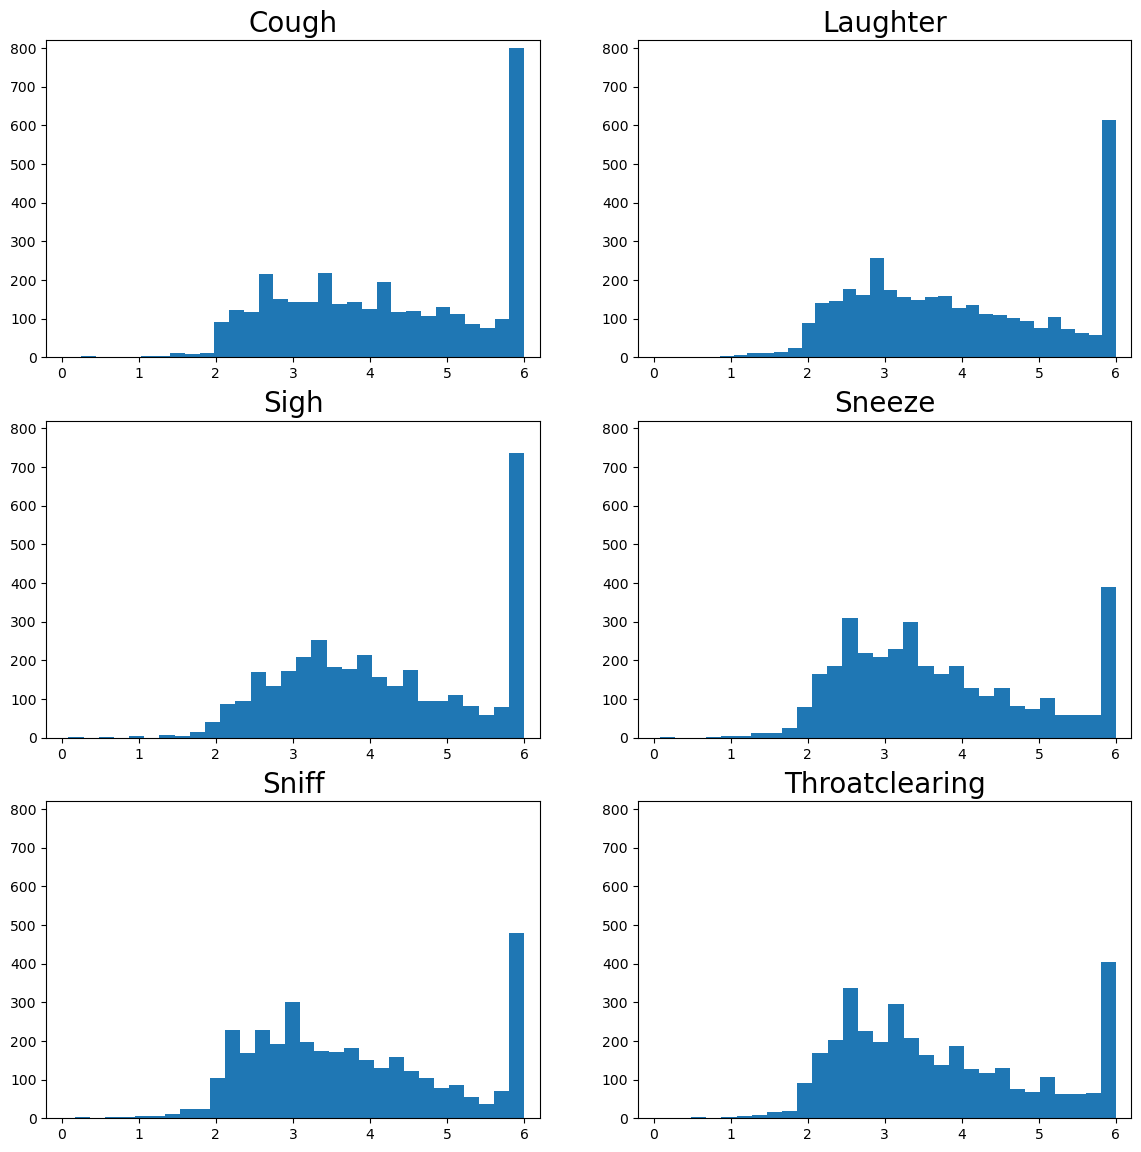

In [16]:
sound_label = ['Cough', 'Laughter', 'Sigh', 'Sneeze', 'Sniff', 'Throatclearing']

plt.figure(figsize = (14,14))
for i in range(6):
    wav_sound = wav[wav['sound'] == i]
    plt.subplot(3,2,i+1)
    plt.hist(wav_sound['duration'], bins = 30)
    plt.xlim([-0.2,6.2])
    plt.ylim([0,820])
    
    plt.title(f'{sound_label[i]}', size = 20);

#### Add Padding

In [17]:
padded_signal = wav['signal'].apply(lambda signal: six_second_pad(signal))

In [20]:
wav['signal'] = padded_signal

In [21]:
wav

,id,age,sex,region,language,file_name,sound,signal,length,duration
0,m0001,36,male,United States of America,EN,m0001_0_cough.wav,0,"[-0.00083185436, -0.0013240844, -0.0005317772,...",54567,2.474694
1,m0001,36,male,United States of America,EN,m0001_0_laughter.wav,1,"[-0.00013598021, 5.812638e-05, 0.000486848, 0....",103488,4.693333
2,m0001,36,male,United States of America,EN,m0001_0_sigh.wav,2,"[-0.00015800091, -5.824324e-05, 0.00037172667,...",63975,2.901361
3,m0001,36,male,United States of America,EN,m0001_0_sneeze.wav,3,"[-0.00028183445, -9.1488546e-05, 0.0004621081,...",82791,3.754694
4,m0001,36,male,United States of America,EN,m0001_0_sniff.wav,4,"[0.0022941753, 0.0029809962, 0.002830814, 0.00...",67738,3.072018
...,...,...,...,...,...,...,...,...,...,...
21019,m3365,28,male,United States of America,EN,m3365_0_laughter.wav,1,"[-0.00032397307, -0.00036792204, 0.00013677347...",52685,2.389342
21020,m3365,28,male,United States of America,EN,m3365_0_sigh.wav,2,"[-8.199582e-07, 2.3996514e-05, 5.6354065e-06, ...",82791,3.754694
21021,m3365,28,male,United States of America,EN,m3365_0_sneeze.wav,3,"[1.46154225e-05, -1.8459732e-06, 3.838355e-05,...",82791,3.754694
21022,m3365,28,male,United States of America,EN,m3365_0_sniff.wav,4,"[-2.5320023e-05, -8.010604e-05, -0.00010303513...",65856,2.986667


## MFCCs

In [42]:
mfccs = wav['signal'].apply(lambda signal: to_mfcc(signal))

In [43]:
mfccs

0        [[-393.60913, -340.68814, -307.5882, -305.7022...
1        [[-481.5669, -459.43304, -442.31342, -428.5260...
2        [[-489.45728, -460.13425, -444.4539, -449.5704...
3        [[-482.08972, -435.9152, -410.57474, -410.7415...
4        [[-440.73138, -351.31, -280.09662, -260.68777,...
                               ...                        
21019    [[-660.8362, -640.6152, -629.5855, -625.66565,...
21020    [[-678.62463, -670.0861, -659.4283, -644.76807...
21021    [[-528.25134, -528.25134, -528.25134, -527.605...
21022    [[-754.2611, -723.5778, -689.46606, -659.9816,...
21023    [[-566.34045, -566.2675, -564.3582, -561.04193...
Name: signal, Length: 20985, dtype: object

In [46]:
mfccs = np.array(mfccs.values.tolist())

In [48]:
np.save(file = '../data/mfccs.npy', arr = mfccs)

In [102]:
non_signal_data = wav.drop(columns = 'signal')
non_signal_data.to_csv('../data/non_signal_data.csv', index = False)

In [99]:
mfccs[0].shape

(20, 259)

In [100]:
mfccs[1].shape

(20, 259)

In [95]:
22050/512

43.06640625

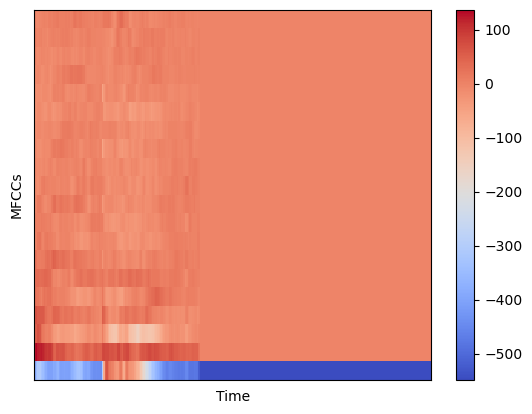

In [97]:
librosa.display.specshow(mfccs[0], n_fft = 2048, hop_length = 512)
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('MFCCs');

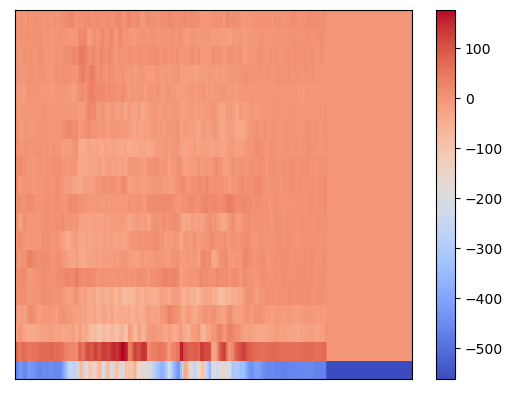

In [55]:
librosa.display.specshow(mfccs[1], n_fft = 2048)
plt.colorbar();

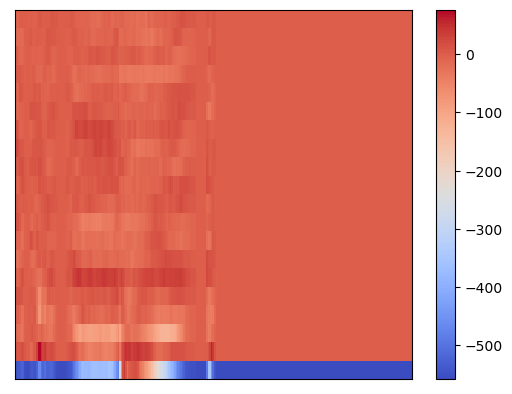

In [62]:
librosa.display.specshow(mfccs[8], n_fft = 2048)
plt.colorbar();

## Standardize

#### Train-Val-Test Split

In [33]:
X = wav.drop(columns = 'sound')
y = wav['sound']

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            stratify = y, 
                                                            test_size = 0.15, 
                                                            random_state = 42)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  stratify = y_train_val,
                                                  test_size = 0.15,
                                                  random_state = 42)

#### Subtract Mean and Divide By Standard Deviation

In [28]:
signal_mean = X_train['signal'].apply(lambda signal: signal.mean())
avg_mean = signal_mean.mean()

In [29]:
signal_std = X_train['signal'].apply(lambda signal: signal.std())
avg_std = signal_std.mean()

In [ ]:
# mean and std only collected from train signal
X_train['signal'] = (X_train['signal'] - avg_mean)/avg_std

In [ ]:
X_val['signal'] = (X_val['signal'] - avg_mean)/avg_std

In [ ]:
X_test['signal'] = (X_test['signal'] - avg_mean)/avg_std

In [19]:
np.array(padded_signal.to_list())

MemoryError: Unable to allocate 10.3 GiB for an array with shape (20985, 132300) and data type float32

#### Saving The Signal As JSON

In [ ]:
wav.to_json('../meta/signal.json')

#### Adding Padding to Shorter Files

## Examples of the Audio Data